In [1]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import numpy as np
from tqdm import tqdm_notebook

### Visualize mask on image

(420, 580)
(420, 580)
(420, 580, 3)


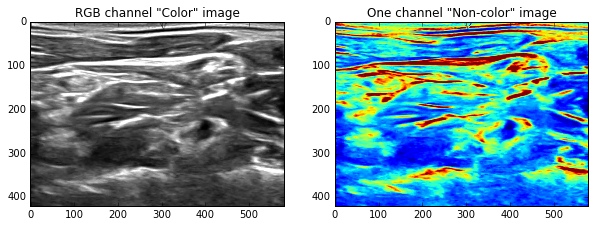

71655
281


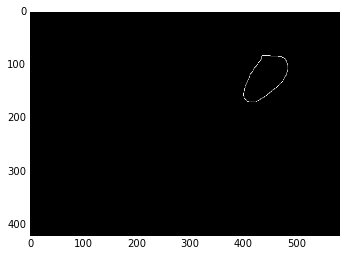

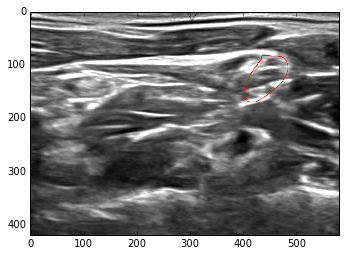

In [3]:
# Using script by Kaggle user Chris Hefele as guide

img = glob.glob('train/1_1.tif')
mask = glob.glob('train/1_1_mask.tif')

img = plt.imread(img[0])
mask = plt.imread(mask[0])
print(img.shape)
print(mask.shape)

img_color = np.dstack((img, img, img))
print(img_color.shape)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('RGB channel "Color" image')
plt.imshow(img_color)
plt.subplot(122)
plt.title('One channel "Non-color" image')
plt.imshow(img)
plt.show()

mask_edges = cv2.Canny(mask, 100, 200)
print(sum(mask_edges.flatten()))
mask_edges = mask_edges > 0
print(sum(mask_edges.flatten()))
plt.imshow(np.dstack((mask_edges, mask_edges, mask_edges)))
plt.show()

img_color[mask_edges != 0, 0] = 255
img_color[mask_edges != 0, 1] = 0
img_color[mask_edges != 0, 2] = 0
plt.imshow(img_color)
plt.show()

In [4]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
b = np.array([0, 1, 1, 1, 1, 0, 0, 0, 0])
# b = np.array([False, True, True, True, True, False, False, False, False])
a[b != 0] = 100
print(a)

[  1 100 100 100 100   6   7   8   9]


### Deeplearning with Keras and Theano?
- I don't currently have theano installed for my windows system :(
- Looking through a script by Kaggle user ZFTurbo


In [5]:
import os

In [6]:
# get_im_cv2

def get_im_cv2(path, img_rows, img_cols):
    img = cv2.imread(path, 0)
    resized = cv2.resize(img, (img_cols, img_rows),
                         cv2.INTER_LINEAR)
    return resized


# Test for image
path = os.path.join('train', '1_1.tif')
# Load the image in greyscale mode
img = cv2.imread(path, 0)
print(img, '\n')

# Resize image with linear interpolation
img_cols = 15
img_rows = 15
img_resized = cv2.resize(img, (img_cols, img_rows),
                     cv2.INTER_LINEAR)
print(img_resized, '\n')

# Test for mask
path = os.path.join('train', '1_1_mask.tif')
# Load the image in greyscale mode
img = cv2.imread(path, 0)
print(img, '\n')

# Resize image with linear interpolation
img_cols = 15
img_rows = 15
img_resized = cv2.resize(img, (img_cols, img_rows),
                     cv2.INTER_LINEAR)
print(img_resized)

[[  0  92  84 ..., 125 111 110]
 [  0 149 135 ..., 143 141 139]
 [  3 140 143 ..., 159 166 168]
 ..., 
 [  0  29  30 ...,  39  37  31]
 [  0  28  33 ...,  37  34  29]
 [  0  26  33 ...,  34  27  26]] 

[[ 86 187 156 148 142 144 165 231 233  96  48  59  80 193 185]
 [ 72  55  63 108 138 139  64  49  99  72  81  45 186 209 202]
 [ 94  59  70 111  90  52  47  37 186  99 102  91  83  65  40]
 [ 68  53 251 255 252 255 255 250 255  71 214 105 168  39  59]
 [117 231 120 197 186 121 175  67  80 120 105 107 128 100  39]
 [ 93 118 150 150 111  97 127 114 134 105  80 115  69  30  43]
 [197 162  98  79  61  93  92  73  77 114 110  73 134  41  27]
 [ 69 174  89  42  52  56  91  97 139  85  55  47  52 192  80]
 [ 47  64  64  68  74 162  64  67 104 198  10 228  60  29  36]
 [ 65 113  83  37  39  38  47 101 177 101  87  86  78 130 108]
 [ 42  59  64  70  25  32  57  87  46 119  64  68  49 135  27]
 [ 58  30  45  31  30  33  30  46  77  70  38  63  80 184 147]
 [ 55  74  70 100 163 187 163 142  92  86 

In [7]:
# Run length encoding function

def rle_encode(img, order='F'):
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []
    r = 0
    pos = 1
    for c in bytes:
        if c == 0:
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    if r != 0:
        runs.append((pos, r))
        pos += r

    z = ''
    for rr in runs:
        z += str(rr[0]) + ' ' + str(rr[1]) + ' '
    return z[:-1]


path = os.path.join('train', '1_1.tif')
# Load the image in greyscale mode
img = cv2.imread(path, 0)
print(img)
# F for Fortran - columns first then rows
order = 'F'
bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
bytes

[[  0  92  84 ..., 125 111 110]
 [  0 149 135 ..., 143 141 139]
 [  3 140 143 ..., 159 166 168]
 ..., 
 [  0  29  30 ...,  39  37  31]
 [  0  28  33 ...,  37  34  29]
 [  0  26  33 ...,  34  27  26]]


array([ 0,  0,  3, ..., 31, 29, 26], dtype=uint8)

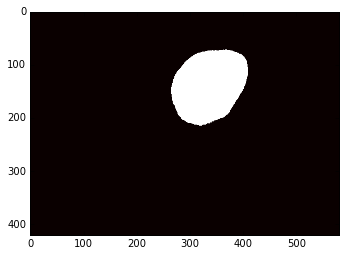

In [84]:
# Finding best mask to assign for positive predictions
# This is clearly an area where I can make improvements

def find_best_mask():
    files = glob.glob(os.path.join("train", "*_mask.tif"))
    overall_mask = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
    overall_mask.fill(0)
    overall_mask = overall_mask.astype(np.float32)

    for fl in files:
        mask = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
        overall_mask += mask
    overall_mask /= 255
    max_value = overall_mask.max()
    koeff = 0.3
    overall_mask[overall_mask < koeff * max_value] = 0
    overall_mask[overall_mask >= koeff * max_value] = 255
    overall_mask = overall_mask.astype(np.uint8)
    return overall_mask

# files = glob.glob(os.path.join("train", "*_mask.tif"))
# overall_mask = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
# print(overall_mask.flatten().sum())

# overall_mask.fill(0)
# print(overall_mask.flatten().sum())

# overall_mask = overall_mask.astype(np.float32)

# for fl in files:
#     mask = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
#     overall_mask += mask
# overall_mask /= 255

# print(overall_mask.flatten().sum())

overall_mask = find_best_mask()
plt.imshow(overall_mask, cmap='hot')

In [14]:
files = glob.glob(os.path.join('train', '*_mask.tif'))
average_mask = np.zeros(shape=cv2.imread(files[0], 0).shape,
                        dtype=np.float32)
for f in files:
    m = cv2.imread(f, 0)
    average_mask += m
    
average_mask.flatten().sum()

7315950.0

In [12]:

average_mask

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [5]:
np.set_printoptions(precision=2)

Area to run things from actual script (modified for my folder system). Frist run cell at bottom, then those directly below.

In [6]:
# read_and_normalize_train_data

img_rows, img_cols = 15, 15
train_data, train_target, train_id = load_train(img_rows, img_cols)
train_data = np.array(train_data, dtype=np.uint8)
train_target = np.array(train_target, dtype=np.uint8)
print('Before reshape:')
print(train_data.shape)
print('e.g.')
print(train_data[0])
train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)
print('\nAfter reshape:')
print(train_data.shape)
print('e.g.')
print(train_data[0])


# Convert to 0 or 1
train_target = get_empty_mask_state(train_target)
print('\nTrain target')
print(train_target)
# The first Keras library dependency
# train_target = np_utils.to_categorical(train_target, 2)
train_data = train_data.astype('float32')
train_data /= 255
print('\nTrain shape:', train_data.shape)
print(train_data.shape[0], 'train samples')
print('e.g.')
print(train_data[0])


Read train images
Read train data time: 0.04 seconds
Before reshape:
(10, 15, 15)
e.g.
[[ 86 187 156 148 142 144 165 231 233  96  48  59  80 193 185]
 [ 72  55  63 108 138 139  64  49  99  72  81  45 186 209 202]
 [ 94  59  70 111  90  52  47  37 186  99 102  91  83  65  40]
 [ 68  53 251 255 252 255 255 250 255  71 214 105 168  39  59]
 [117 231 120 197 186 121 175  67  80 120 105 107 128 100  39]
 [ 93 118 150 150 111  97 127 114 134 105  80 115  69  30  43]
 [197 162  98  79  61  93  92  73  77 114 110  73 134  41  27]
 [ 69 174  89  42  52  56  91  97 139  85  55  47  52 192  80]
 [ 47  64  64  68  74 162  64  67 104 198  10 228  60  29  36]
 [ 65 113  83  37  39  38  47 101 177 101  87  86  78 130 108]
 [ 42  59  64  70  25  32  57  87  46 119  64  68  49 135  27]
 [ 58  30  45  31  30  33  30  46  77  70  38  63  80 184 147]
 [ 55  74  70 100 163 187 163 142  92  86  71 128 115  97 178]
 [ 76  85  77 185  71  80  68  55  55  62  57  66  76  80  91]
 [ 41  53  51  39  52  56  64  

In [2]:
# -*- coding: utf-8 -*-
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import numpy as np
np.random.seed(2016)
import os
import glob
import cv2
import datetime
import time
from sklearn.cross_validation import KFold
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Flatten
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
# from keras.optimizers import Adam
# from keras.optimizers import SGD
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
from sklearn.metrics import log_loss


def get_im_cv2(path, img_rows, img_cols):
    img = cv2.imread(path, 0)
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized


def load_train(img_rows, img_cols):
    X_train = []
    X_train_id = []
    mask_train = []
    start_time = time.time()

    print('Read train images')
    files = glob.glob("train/*[0-9].tif")
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols)
        X_train.append(img)
        X_train_id.append(flbase[:-4])
        mask_path = "train/" + flbase[:-4] + "_mask.tif"
        mask = get_im_cv2(mask_path, img_rows, img_cols)
        mask_train.append(mask)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, mask_train, X_train_id


def load_test(img_rows, img_cols):
    print('Read test images')
    files = glob.glob("test/*[0-9].tif")
    X_test = []
    X_test_id = []
    total = 0
    start_time = time.time()
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols)
        X_test.append(img)
        X_test_id.append(flbase[:-4])
        total += 1

    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, X_test_id


def rle_encode(img, order='F'):
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []
    r = 0
    pos = 1
    for c in bytes:
        if c == 0:
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    if r != 0:
        runs.append((pos, r))
        pos += r

    z = ''
    for rr in runs:
        z += str(rr[0]) + ' ' + str(rr[1]) + ' '
    return z[:-1]


def find_best_mask():
    files = glob.glob(os.path.join("train", "*_mask.tif"))
    overall_mask = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
    overall_mask.fill(0)
    overall_mask = overall_mask.astype(np.float32)

    for fl in files:
        mask = cv2.imread(fl, cv2.IMREAD_GRAYSCALE)
        overall_mask += mask
    overall_mask /= 255
    max_value = overall_mask.max()
    koeff = 0.5
    overall_mask[overall_mask < koeff * max_value] = 0
    overall_mask[overall_mask >= koeff * max_value] = 255
    overall_mask = overall_mask.astype(np.uint8)
    return overall_mask


def create_submission(predictions, test_id, info):
    sub_file = os.path.join('submission_' + info + '_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv')
    subm = open(sub_file, "w")
    mask = find_best_mask()
    encode = rle_encode(mask)
    subm.write("img,pixels\n")
    for i in range(len(test_id)):
        subm.write(str(test_id[i]) + ',')
        if predictions[i][1] > 0.5:
            subm.write(encode)
        subm.write('\n')
    subm.close()


def get_empty_mask_state(mask):
    out = []
    for i in range(len(mask)):
        if mask[i].sum() == 0:
            out.append(0)
        else:
            out.append(1)
    return np.array(out)


def read_and_normalize_train_data(img_rows, img_cols):
    train_data, train_target, train_id = load_train(img_rows, img_cols)
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)
    # Convert to 0 or 1
    train_target = get_empty_mask_state(train_target)
    train_target = np_utils.to_categorical(train_target, 2)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, train_id


def read_and_normalize_test_data(img_rows, img_cols):
    test_data, test_id = load_test(img_rows, img_cols)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], 1, img_rows, img_cols)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

### Keras loss plots (my cNN script - based on ZFTurbo's code)

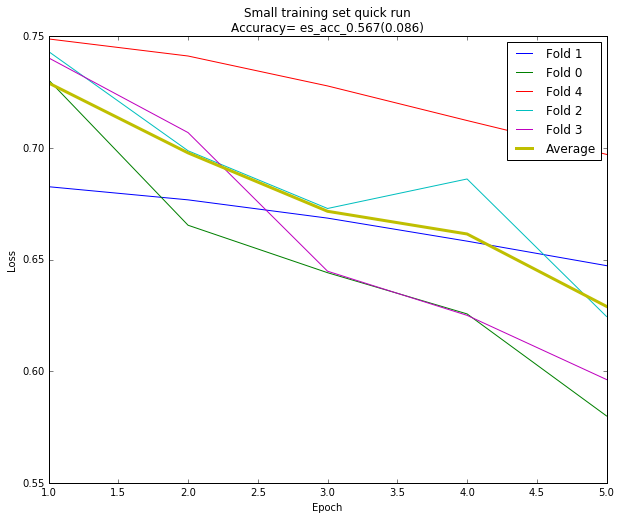

In [8]:
import json

def plot_kf_scores(title, kf_scores_file):
    
    kf_scores = json.load(open(kf_scores_file, 'r'))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    for k, v in kf_scores.items():
        ax.plot(range(1,len(v)+1), v, label='Fold {}'.format(k))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

    ax.plot(range(1,len(v)+1), np.mean([v for v in kf_scores.values()], axis=0),
            label='Average', lw=3)

    ax.set_title(title+'\nAccuracy= '+kf_scores_file[14:-5])
    plt.legend()
    plt.show()

plot_kf_scores('Small training set quick run', 'smalls/kf_scores_acc_0.567(0.086).json')

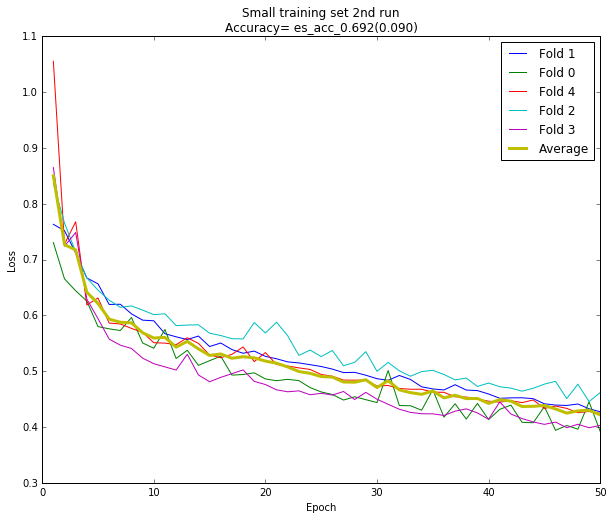

In [9]:
plot_kf_scores('Small training set 2nd run', 'smalls/kf_scores_acc_0.692(0.090).json')

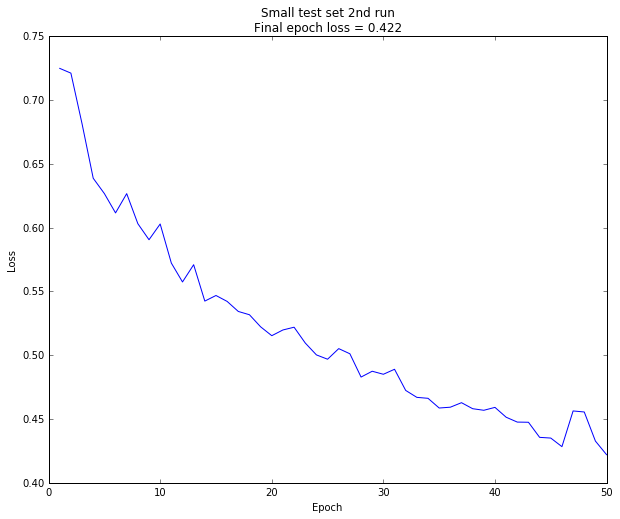

In [11]:
def plot_test_scores(title, test_scores_file):
    
    scores = json.load(open(test_scores_file, 'r'))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax.plot(range(1,len(scores)+1), scores)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    
    ax.set_title(title+'\nFinal epoch loss = '+test_scores_file[19:-5])
    plt.show()
    
plot_test_scores('Small test set 2nd run', 'smalls/test_scores_0.422.json')